In [19]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec

import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold

from sklearn.base import clone as sklearn_clone

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

## Lodad data

In [20]:
df_topics = pd.read_csv('../datasets/ready2use/topics.csv', index_col=0)
df_topics.shape

(6541, 1)

In [21]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

y_train = df.copy()['assestment'][df.index.isin(df_topics.index)]

X_train = df.copy()['text_clean'][df.index.isin(df_topics.index)]

In [22]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")
model = AutoModel.from_pretrained("allegro/herbert-large-cased")

Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
if False:
    embeddings_table = np.zeros((X_train.shape[0], 1024))

    for i, t in enumerate(tqdm(X_train.values)):
        encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True)
        output = model(**encoded_input)[0][:,0]
        embeddings_table[i,:] = output.detach().numpy()
    
    np.savetxt('../datasets/ready2use/embeddings_pl_herbert.csv', embeddings_table, delimiter=",")
else:
    embeddings_table = pd.read_csv('../datasets/ready2use/embeddings_pl_herbert.csv', sep=",", header=None).values

In [24]:
embeddings_table.shape

(6541, 1024)

In [25]:
y_train.shape

(6541,)

### Kfold

In [26]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [27]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Experiments

In [28]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [29]:
def run_experiment_h(X, y, cv, clf_org, use_pca=False):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }

    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)
        
        y_train_t = y[train_cv]
        X_train_t = X[train_cv, :]
        y_test_t = y[test_cv] 
        X_test_t = X[test_cv, :]
        
        if use_pca:
            pca = PCA(n_components=100)
            pca.fit(X_train_t)

            X_train_t = pca.transform(X_train_t)
            X_test_t = pca.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics

In [31]:
out = run_experiment_h(embeddings_table, y_train.values, cv_fold_i, clf_lr_1)
print(
    'herbert lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]

herbert lr C1 Accuracy 0.696+-0.016 F1 Score 0.675+-0.035  0.696+-0.016 | 0.675+-0.035


In [32]:
out = run_experiment_h(embeddings_table, y_train.values, cv_fold_i, clf_lr_1, True)
print(
    'herbert PCA 100 lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]

herbert PCA 100 lr C1 Accuracy 0.689+-0.013 F1 Score 0.664+-0.051  0.689+-0.013 | 0.664+-0.051


In [33]:
out = run_experiment_h(embeddings_table, y_train.values, cv_Kfold_i, clf_lr_1)
print(
    'herbert lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]

herbert lr C1 Accuracy 0.696+-0.013 F1 Score 0.683+-0.018  0.696+-0.013 | 0.683+-0.018


In [34]:
out = run_experiment_h(embeddings_table, y_train.values, cv_Kfold_i, clf_lr_1, True)
print(
    'herbert lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|███████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]

herbert lr C1 Accuracy 0.695+-0.009 F1 Score 0.680+-0.017  0.695+-0.009 | 0.680+-0.017


### trying to visualise the results

In [29]:
import umap  # pip install umap-learn

In [34]:
X = embeddings_table

for train_cv, test_cv in cv_Kfold_i:

    y_train_t = y_train.values[train_cv]
    X_train_t = X[train_cv, :]
    y_test_t = y_train.values[test_cv] 
    X_test_t = X[test_cv, :]
    
    break

In [35]:
manifold = umap.UMAP().fit(X_train_t, y_train_t)
X_reduced = manifold.transform(X_train_t)

In [36]:
X_reduced_test = manifold.transform(X_test_t)

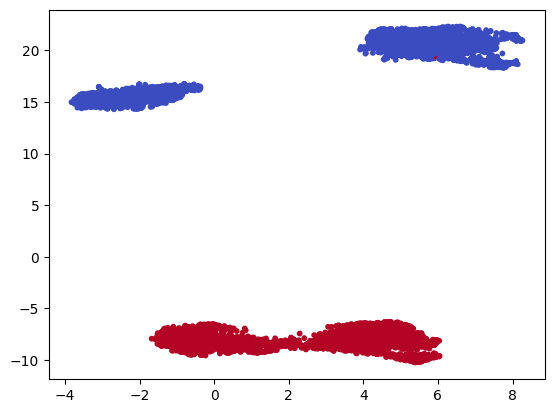

In [38]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train_t, s=10, cmap='coolwarm')

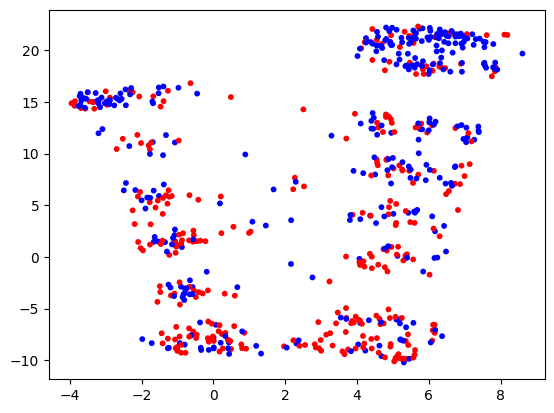

In [39]:
plt.scatter(X_reduced_test[:, 0], X_reduced_test[:, 1], c=y_test_t, s=10, cmap='bwr')